In [374]:
# Import libraries
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [375]:
# Set variables

filepath = '../processed'
fps = 30                    # frames per second
baseline = 1                # pre-stimulus baseline (secs)
cs_dur = 4                  # CS duration (secs); note that last 2 secs coincide with shock
cr_dur = 2                  # Length of CS period to measure CR

In [376]:
def compute_angular_speed(behavior):
    # Sort the dataframe by ID and frame to ensure correct order
    behavior.sort_values(by=['ID', 'frame'], inplace=True)

    # Calculate differences
    behavior['dx'] = behavior.groupby('ID')['x'].diff()
    behavior['dy'] = behavior.groupby('ID')['y'].diff()
    behavior['dt'] = behavior.groupby('ID')['frame'].diff()*fps

    # Calculate the change in angle (dtheta) using arctangent
    behavior['dtheta'] = np.arctan2(behavior['dy'], behavior['dx'])

    # Calculate angular speed (omega)
    behavior['angular_speed'] = behavior['dtheta'] / behavior['dt']

    # Handle NaN values that result from the diff() operation
    behavior.fillna(0, inplace=True)
    
    return behavior

In [377]:
# Function for extracting average speed
def get_avg_speed(timestamps,behavior):
    # Filter the timestamps for CS and event "on"
    timestamps['event'].str.lower()
    cs_on_events = timestamps[(timestamps['stimulus'] == 'CS') & (timestamps['event'] == 'on')]

    # Initialize a list to store the results
    results = []
    trial = 0

    # Iterate through the filtered "on" events
    for _, on_event in cs_on_events.iterrows():
        on_frame = on_event['frame']
        trial = trial + 1
        
        # Find the corresponding "off" event
        off_event = timestamps[(timestamps['stimulus'] == 'CS') & 
                            (timestamps['event'] == 'off') & 
                            (timestamps['frame'] > on_frame)].iloc[0]
        
        off_frame = off_event['frame']
        
        # Get the frames between on and off in the behavior dataframe
        behavior_segment = behavior[(behavior['frame'] >= on_frame) & (behavior['frame'] <= off_frame-(cs_dur-cr_dur)*fps)]
        avg_speed_during = behavior_segment['angular_speed'].mean()
        
        # Get the frames 30 frames prior to the on event
        pre_on_frame_start = max(on_frame - fps*baseline, 0)  # Ensure we don't go below frame 0
        pre_on_segment = behavior[(behavior['frame'] >= pre_on_frame_start) & (behavior['frame'] < on_frame)]
        avg_speed_pre = pre_on_segment['angular_speed'].mean()
        
        # Calculate the adjusted average speed
        adjusted_avg_speed = avg_speed_during - avg_speed_pre
        
        # Store the result
        results.append({
            'trial': trial,
            'on_frame': on_frame,
            'off_frame': off_frame,
            'avg_speed_during': avg_speed_during,
            'avg_speed_pre': avg_speed_pre,
            'adjusted_avg_speed': adjusted_avg_speed
        })

    # Convert the results into a DataFrame
    return pd.DataFrame(results)

In [378]:
# Load data and extract average speed

results = pd.DataFrame(columns = ['trial', 'avg_speed', 'sample', 'condition'])

for f in os.listdir(filepath):
    if f.endswith("_timestamps.csv") and not(f.startswith("Random")):
        print(f)
        
        # Load timestamps
        timestamps = pd.read_csv(os.path.join(filepath,f))
        timestamps['event'] = timestamps['event'].apply(lambda x: x.lower() if isinstance(x, str) else x) # get rid of capitalization
        
        # Load behavior
        p = f.split("_")
        g = "_".join([p[0],p[1],'behavior.csv'])
        behavior = pd.read_csv(os.path.join(filepath,g))
        behavior = compute_angular_speed(behavior)
        
        # Extract average speed for each trial
        df = get_avg_speed(timestamps,behavior)
        df["sample"] = p[1]
        df["condition"] = p[0]
        
        results = pd.concat([results,df], ignore_index=True)
        
        
        
        

1000mV_Sample02_timestamps.csv
TrulyRandomControl_Sample02_timestamps.csv
3200mV_Sample00_timestamps.csv
6900mV_Sample01_timestamps.csv
10200mV_Sample00_timestamps.csv
10200mV_Sample01_timestamps.csv
6900mV_Sample00_timestamps.csv
1500mV_Sample03_timestamps.csv
TrulyRandomControl_Sample03_timestamps.csv
3200mV_Sample01_timestamps.csv
1000mV_Sample03_timestamps.csv
3200mV_Sample03_timestamps.csv
TrulyRandomControl_Sample01_timestamps.csv
1000mV_Sample01_timestamps.csv
6900mV_Sample02_timestamps.csv
10200mV_Sample03_timestamps.csv
10200mV_Sample02_timestamps.csv
6900mV_Sample03_timestamps.csv
1000mV_Sample00_timestamps.csv
3200mV_Sample02_timestamps.csv
2200mV_Sample02_timestamps.csv
4700mV_Sample00_timestamps.csv
15000mV_Sample02_timestamps.csv
4700mV_Sample01_timestamps.csv
15000mV_Sample03_timestamps.csv
2200mV_Sample03_timestamps.csv
15000mV_Sample01_timestamps.csv
4700mV_Sample03_timestamps.csv
2200mV_Sample01_timestamps.csv
2200mV_Sample00_timestamps.csv
4700mV_Sample02_timestamps.

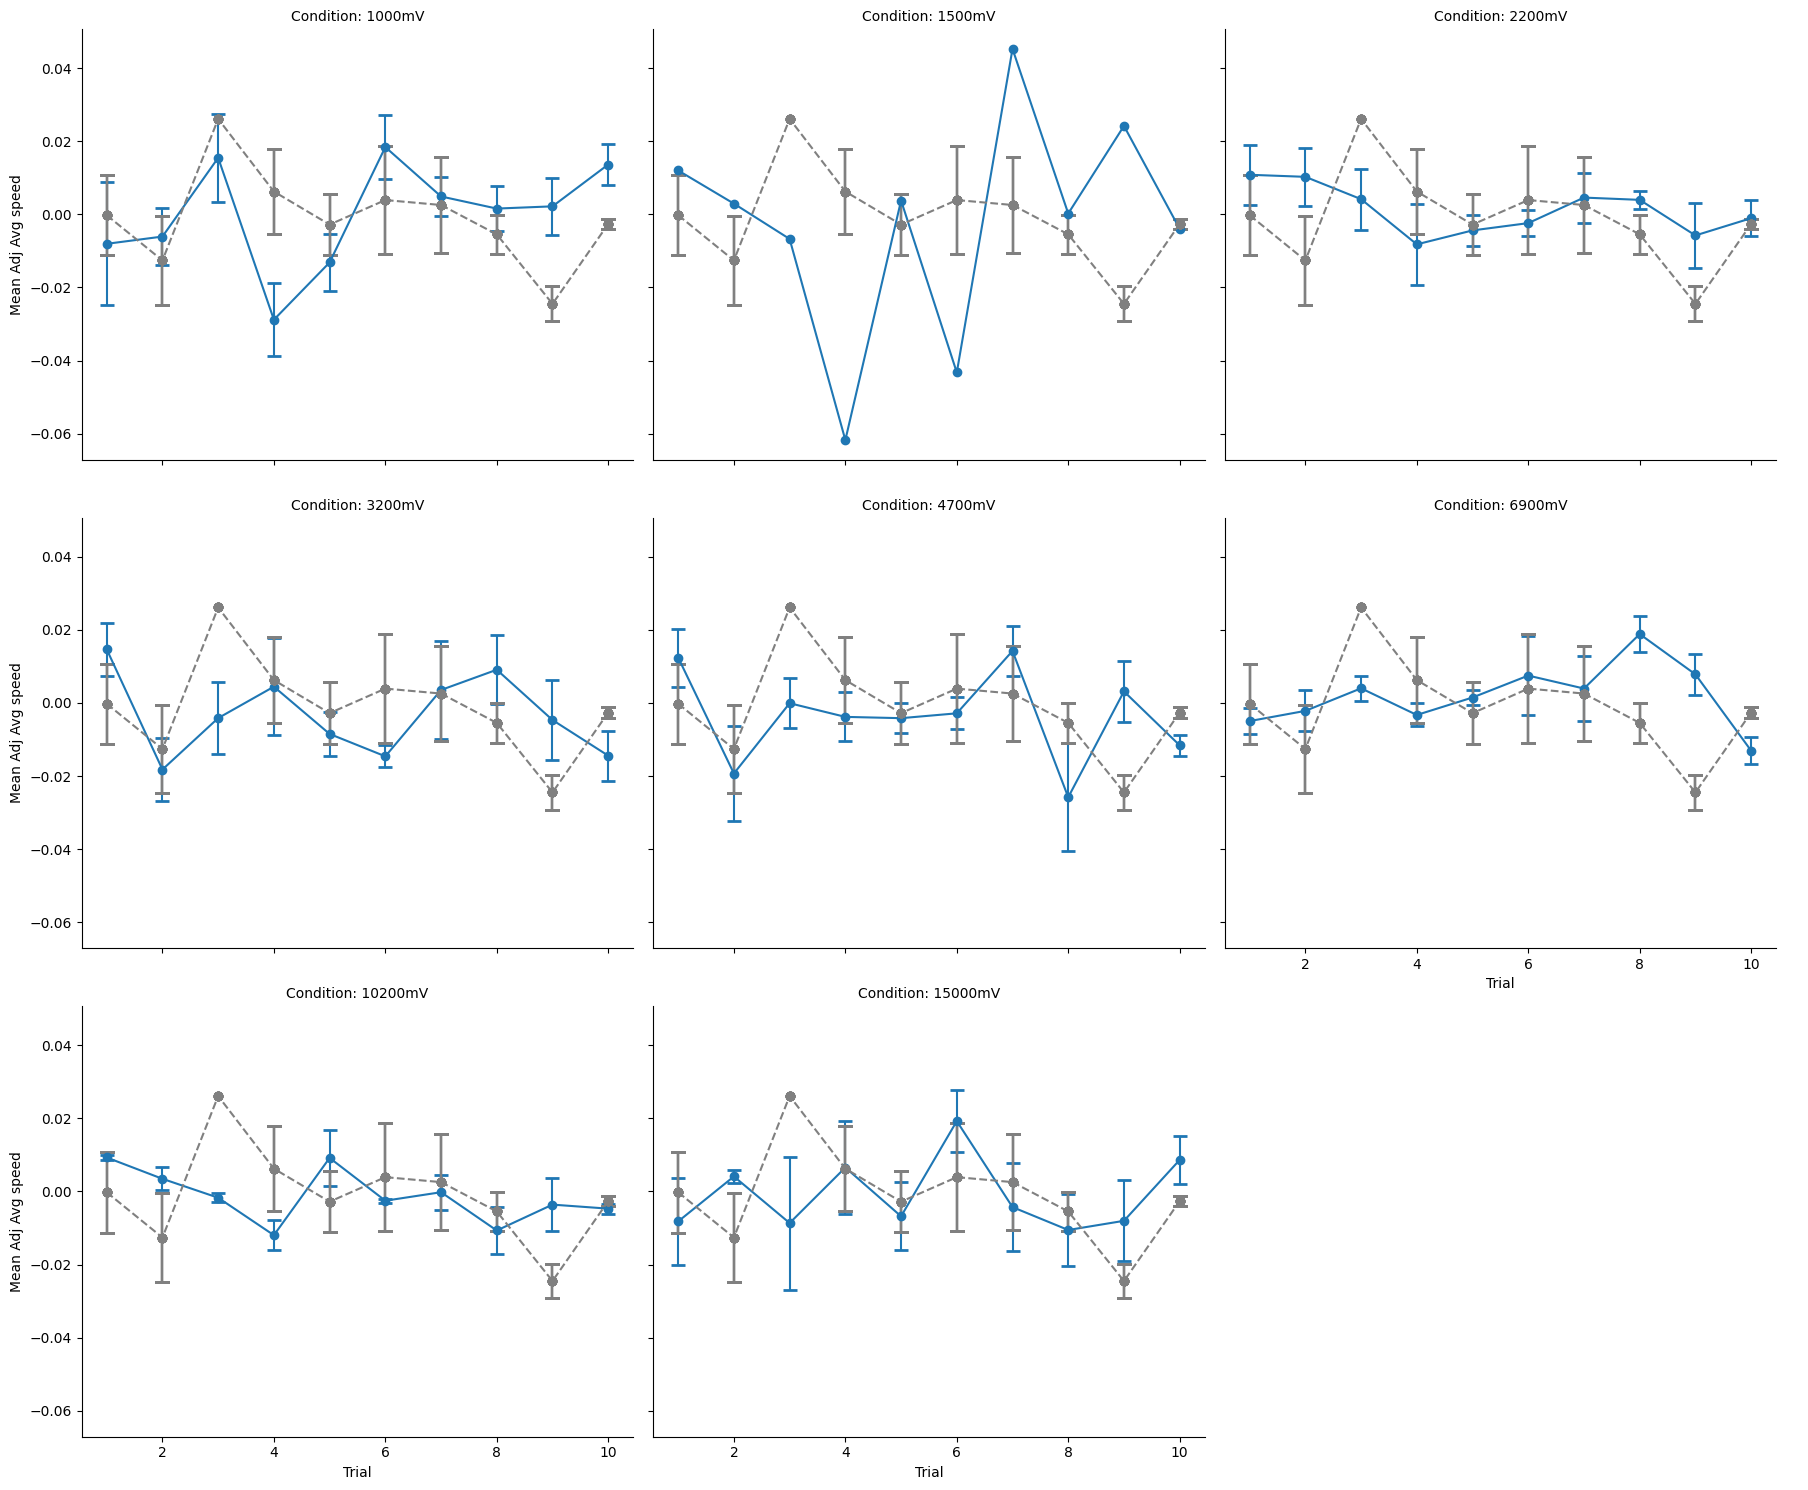

In [379]:
# Plot results

# Which variable to analyze
v = 'adjusted_avg_speed'

# Drop missing values
df = results.dropna(subset=v)

# Calculate mean and standard error
grouped = df.groupby(['trial', 'condition']).agg(
    mean_speed=(v, 'mean'),
    count=(v, 'size'),
    std_speed=(v, 'std')).reset_index()

# Drop trials > 10 (upper limit of # training trials except for Truly Random Control)
grouped = grouped.drop(grouped[grouped['trial'] >10].index)

# Calculate standard error of the mean
grouped['se_speed'] = grouped['std_speed'] / grouped['count']**0.5

# Calculate mean and standard error for the condition to be plotted in all panels (e.g., condition 'A')
shared_condition = 'TrulyRandomControl'
shared_grouped = grouped[grouped['condition'] == shared_condition].copy()

# Merge the shared condition data back to main DataFrame
grouped = grouped.merge(shared_grouped[['trial', 'mean_speed', 'se_speed']], on='trial', how='left', suffixes=('', f'_{shared_condition}'))

# Initialize the FacetGrid object
cond_order = ['1000mV', '1500mV', '2200mV', '3200mV', '4700mV', '6900mV', '10200mV', '15000mV']
g = sns.FacetGrid(grouped, col="condition", col_order=cond_order, sharey=True, height=5, aspect=1.2, col_wrap=3)

# Add the line plot to each facet
g.map(plt.errorbar, "trial", "mean_speed", "se_speed", marker='o', capsize=5, capthick=2)

# Add the line plot for the shared condition (e.g., condition 'A') in all panels
for ax in g.axes.flat:
    ax.errorbar(grouped['trial'], grouped[f'mean_speed_{shared_condition}'], yerr=grouped[f'se_speed_{shared_condition}'], marker='o', linestyle='--', color='grey', capsize=5, capthick=2)

# Add axis labels and a title
g.set_axis_labels("Trial", "Mean Adj Avg speed")
g.set_titles(col_template="Condition: {col_name}")
g.add_legend()

# Show the plot
plt.show()